<a href="https://colab.research.google.com/github/Hyemmingway/ai_teamplay/blob/main/KSL_mp_select_oversampling_not%20ag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 모듈 불러오기

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import os
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

import pickle
import cv2
#import mediapipe as mp

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. 데이터 확인

In [35]:
#한 폴더당 중심 동작 20개씩 뽑음
select_df=pd.read_csv('/content/drive/MyDrive/2022-2 ipynb/AISTAT/num5 data/DF_mp_select_20_oversampling.csv')
select_df

,name,fold,class,num,path,label
0,00_01.0046.jpg,00_01,1,46,/content/drive/MyDrive/2022-2 ipynb/AISTAT/num...,hi
1,00_01.0047.jpg,00_01,1,47,/content/drive/MyDrive/2022-2 ipynb/AISTAT/num...,hi
2,00_01.0048.jpg,00_01,1,48,/content/drive/MyDrive/2022-2 ipynb/AISTAT/num...,hi
3,00_01.0049.jpg,00_01,1,49,/content/drive/MyDrive/2022-2 ipynb/AISTAT/num...,hi
4,00_07.0035.jpg,00_07,7,35,/content/drive/MyDrive/2022-2 ipynb/AISTAT/num...,me
...,...,...,...,...,...,...
2655,00_13.0050.jpg,00_13,13,50,/content/drive/MyDrive/2022-2 ipynb/AISTAT/num...,thank
2656,08_13.0071.jpg,08_13,13,71,/content/drive/MyDrive/2022-2 ipynb/AISTAT/num...,thank
2657,05_13.0021.jpg,05_13,13,21,/content/drive/MyDrive/2022-2 ipynb/AISTAT/num...,thank
2658,14_13.0073.jpg,14_13,13,73,/content/drive/MyDrive/2022-2 ipynb/AISTAT/num...,thank


In [36]:
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)
train_generator = datagen.flow_from_dataframe(
          dataframe=select_df,
          batch_size=128,
          class_mode='categorical',
          shuffle=True,
          x_col='path',
          y_col='label',
          subset = 'training')

valid_generator = datagen.flow_from_dataframe(
          dataframe=select_df,
          batch_size=128,
          class_mode='categorical',
          shuffle=True,
          x_col='path',
          y_col='label',
          subset = 'validation')

Found 1995 validated image filenames belonging to 10 classes.
Found 665 validated image filenames belonging to 10 classes.


### CNN

In [37]:
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow import keras

In [38]:
from keras.callbacks import ModelCheckpoint

In [39]:
pool_size = 2
    
model1 = Sequential([
  keras.Input(shape=(256,256,3)),
  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),
  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),                                           
  MaxPooling2D(pool_size=pool_size),                         

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),   
  MaxPooling2D(pool_size=pool_size),                         

  Conv2D(filters = 80, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 80, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),   
  MaxPooling2D(pool_size=pool_size),                         

  Flatten(),
  Dense(50),
  Activation('relu'),                                          
  
  Dense(10, activation='softmax'),
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 30)      840       
                                                                 
 batch_normalization_6 (Batc  (None, 256, 256, 30)     120       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 256, 256, 30)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 30)      8130      
                                                                 
 batch_normalization_7 (Batc  (None, 256, 256, 30)     120       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 256, 256, 30)     

In [40]:
model1.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [41]:
checkpoint_filepath = '/content/drive/MyDrive/2022-2 ipynb/AISTAT/num5 data' + 'best_model1_{val_accuracy:.4f}.ckpt'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [42]:
#cnn
history1= model1.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    shuffle=True)

Epoch 1/15
16/16 [==============================] - 499s 32s/step - loss: 9.9590 - accuracy: 0.3098 - val_loss: 12.2270 - val_accuracy: 0.1564
Epoch 2/15
16/16 [==============================] - 14s 885ms/step - loss: 1.6557 - accuracy: 0.5534 - val_loss: 3.4305 - val_accuracy: 0.1353
Epoch 3/15
16/16 [==============================] - 15s 902ms/step - loss: 1.0227 - accuracy: 0.6647 - val_loss: 2.6745 - val_accuracy: 0.1008
Epoch 4/15
16/16 [==============================] - 14s 883ms/step - loss: 0.7784 - accuracy: 0.7524 - val_loss: 2.9018 - val_accuracy: 0.0902
Epoch 5/15
16/16 [==============================] - 14s 875ms/step - loss: 0.6185 - accuracy: 0.7970 - val_loss: 3.0712 - val_accuracy: 0.0902
Epoch 6/15
16/16 [==============================] - 14s 869ms/step - loss: 0.5118 - accuracy: 0.8346 - val_loss: 3.1859 - val_accuracy: 0.0902
Epoch 7/15
16/16 [==============================] - 14s 874ms/step - loss: 0.4493 - accuracy: 0.8521 - val_loss: 3.2811 - val_accuracy: 0.0902

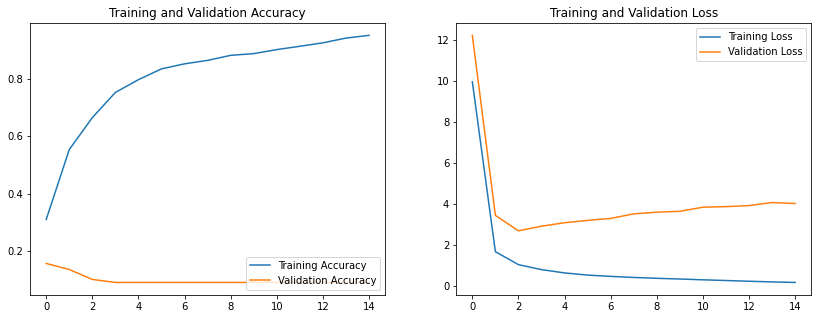

In [43]:

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


### CNN + dropout

In [44]:
pool_size = 2
    
model3 = Sequential([
  keras.Input(shape=(256,256,3)),
  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),
  Conv2D(filters = 30, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),                                           
  MaxPooling2D(pool_size=pool_size),                         

  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 50, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),   
  MaxPooling2D(pool_size=pool_size),                         

  Conv2D(filters = 80, kernel_size = (3,3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(filters = 80, kernel_size = (3,3), padding='same'),  
  BatchNormalization(),                                       
  Activation('relu'),   
  MaxPooling2D(pool_size=pool_size),                         

  Flatten(),
  Dense(50),
  Activation('relu'),                                          
  Dropout(0.5),
  Dense(10, activation='softmax'),
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 30)      840       
                                                                 
 batch_normalization_6 (Batc  (None, 256, 256, 30)     120       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 256, 256, 30)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 30)      8130      
                                                                 
 batch_normalization_7 (Batc  (None, 256, 256, 30)     120       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 256, 256, 30)     

In [45]:
model3.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [46]:
checkpoint_filepath = '/content/drive/MyDrive/2022-2 ipynb/AISTAT/num5 data' + 'best_model3_{val_accuracy:.4f}.ckpt'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [47]:
#cnn
history3 = model3.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    shuffle=True)

Epoch 1/15
16/16 [==============================] - 16s 921ms/step - loss: 6.5895 - accuracy: 0.1203 - val_loss: 2.3036 - val_accuracy: 0.0436
Epoch 2/15
16/16 [==============================] - 14s 879ms/step - loss: 2.1743 - accuracy: 0.1845 - val_loss: 2.3052 - val_accuracy: 0.0226
Epoch 3/15
16/16 [==============================] - 14s 883ms/step - loss: 2.1389 - accuracy: 0.2015 - val_loss: 2.3066 - val_accuracy: 0.0226
Epoch 4/15
16/16 [==============================] - 14s 874ms/step - loss: 2.1518 - accuracy: 0.1935 - val_loss: 2.3079 - val_accuracy: 0.0226
Epoch 5/15
16/16 [==============================] - 14s 874ms/step - loss: 2.1249 - accuracy: 0.2035 - val_loss: 2.3091 - val_accuracy: 0.0226
Epoch 6/15
16/16 [==============================] - 14s 875ms/step - loss: 2.1224 - accuracy: 0.2040 - val_loss: 2.3104 - val_accuracy: 0.0226
Epoch 7/15
16/16 [==============================] - 14s 875ms/step - loss: 2.1338 - accuracy: 0.1985 - val_loss: 2.3115 - val_accuracy: 0.0226

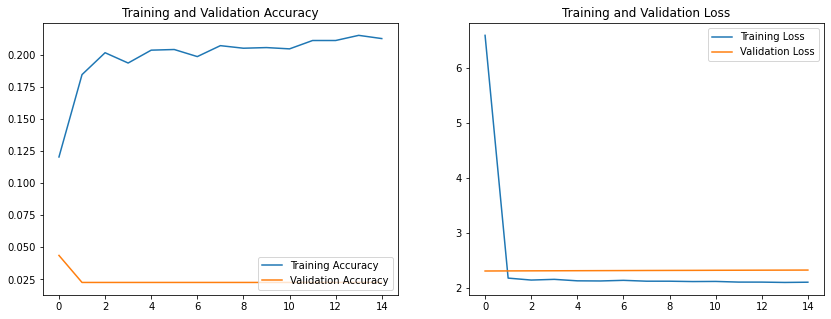

In [48]:

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


### CNN+LSTM

In [49]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D,\
                        Permute, TimeDistributed, Bidirectional,GRU, LeakyReLU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Reshape
from keras import models
from keras import layers
import tensorflow as tf

In [50]:
Model = Sequential()

Model.add(SeparableConv2D(12,(3,3),activation="relu",
                 input_shape=(256,256,3)))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2,2)))

#
Model.add(SeparableConv2D(24,(3,3),
                 activation="relu",padding="same"))
Model.add(Dropout(0.2))
Model.add(MaxPooling2D((2,2)))

#
Model.add(TimeDistributed(Flatten()))
Model.add(Bidirectional(LSTM(64,
                                  return_sequences=True,
                                  dropout=0.5,
                                  recurrent_dropout=0.5)))
Model.add(Bidirectional(LSTM(64,
                                  return_sequences=True,
                                  dropout=0.5,
                                  recurrent_dropout=0.5)))

#
Model.add(Flatten())
Model.add(Dense(128,activation="relu"))
Model.add(Dropout(0.5))
Model.add(Dense(10,activation="sigmoid"))

In [51]:
Model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [52]:
checkpoint_filepath = '/content/drive/MyDrive/2022-2 ipynb/AISTAT/num5 data' + 'best_model2_{val_accuracy:.4f}.ckpt'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [53]:
history2= Model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    shuffle=True)

Epoch 1/10
16/16 [==============================] - 42s 2s/step - loss: 1.9346 - accuracy: 0.3258 - val_loss: 2.2604 - val_accuracy: 0.0962
Epoch 2/10
16/16 [==============================] - 32s 2s/step - loss: 0.8841 - accuracy: 0.7048 - val_loss: 2.0673 - val_accuracy: 0.2256
Epoch 3/10
16/16 [==============================] - 31s 2s/step - loss: 0.5647 - accuracy: 0.8095 - val_loss: 2.0080 - val_accuracy: 0.2857
Epoch 4/10
16/16 [==============================] - 31s 2s/step - loss: 0.3776 - accuracy: 0.8687 - val_loss: 1.9126 - val_accuracy: 0.4000
Epoch 5/10
16/16 [==============================] - 33s 2s/step - loss: 0.2498 - accuracy: 0.9213 - val_loss: 1.7884 - val_accuracy: 0.4526
Epoch 6/10
16/16 [==============================] - 31s 2s/step - loss: 0.1909 - accuracy: 0.9419 - val_loss: 1.7004 - val_accuracy: 0.4947
Epoch 7/10
16/16 [==============================] - 31s 2s/step - loss: 0.1355 - accuracy: 0.9559 - val_loss: 1.6028 - val_accuracy: 0.5880
Epoch 8/10
16/16 [==

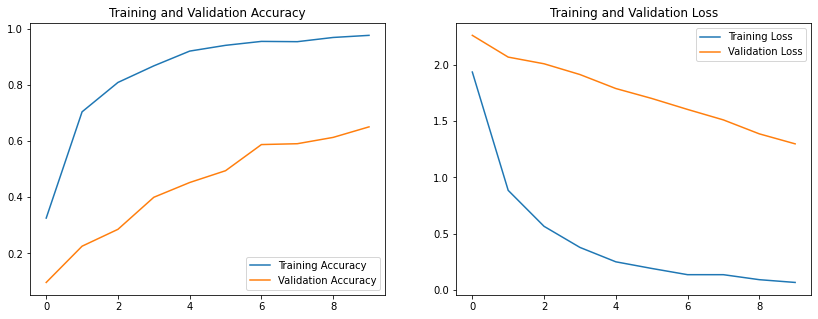

In [54]:

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


### googlenet + imceptionV

In [55]:

import os
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

import pickle
import cv2

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input #InceptionV3, Xception, InceptionResNetV2
#from keras.applications.imagenet_utils import preprocess_input #others
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization

from tensorflow import keras
from PIL import Image
import tensorflow as tf

from keras.callbacks import ModelCheckpoint

In [57]:

InceptionV3(
    include_top=True, # classification (softmax) 부분을 포함할 것인지 선택하는 것입니다.
    weights="imagenet", # imageNet으로 pre-trained 된 모델을 받을 것인지를 선택하는 것입니다. 만약 pre-trained 된 모델을 받길 원하지 않는다면 None으로 넣으면 됩니다.
    input_tensor=None, 
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

96112376/96112376 [==============================] - 5s 0us/step


In [58]:

base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg') #Downloading data from https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5

#base_model.summary()

net = Dense(units=10)(base_model.output)
net = Activation('softmax')(net)
model4 = Model(inputs=base_model.input, outputs=net)

model4.summary()

87910968/87910968 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_112 (Conv2D)            (None, None, None,   864         ['input_5[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_113 (Batch  (None, None, None,   96         ['conv2d_112[0][0]']             
 Normalization)              

In [59]:

checkpoint_filepath = '/content/drive/MyDrive/2022-2 ipynb/AISTAT/num5 data' + 'best_model4_{val_accuracy:.4f}.ckpt'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
     

In [60]:
model4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [61]:

history4 = model4.fit(
          train_generator,
          epochs=10,
          validation_data=valid_generator, 
          callbacks=[model_checkpoint_callback]
)
     

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.7769
Epoch 1: val_accuracy improved from -inf to 0.07820, saving model to /content/drive/MyDrive/2022-2 ipynb/AISTAT/num5 databest_model4_0.0782.ckpt
16/16 [==============================] - 51s 2s/step - loss: 0.6759 - accuracy: 0.7769 - val_loss: 16.5495 - val_accuracy: 0.0782
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9810
Epoch 2: val_accuracy improved from 0.07820 to 0.12932, saving model to /content/drive/MyDrive/2022-2 ipynb/AISTAT/num5 databest_model4_0.1293.ckpt
16/16 [==============================] - 23s 1s/step - loss: 0.0813 - accuracy: 0.9810 - val_loss: 14.6948 - val_accuracy: 0.1293
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9885
Epoch 3: val_accuracy did not improve from 0.12932
16/16 [==============================] - 22s 1s/step - loss: 0.0495 - accuracy: 0.9885 - val_loss: 8.7876 - val_ac

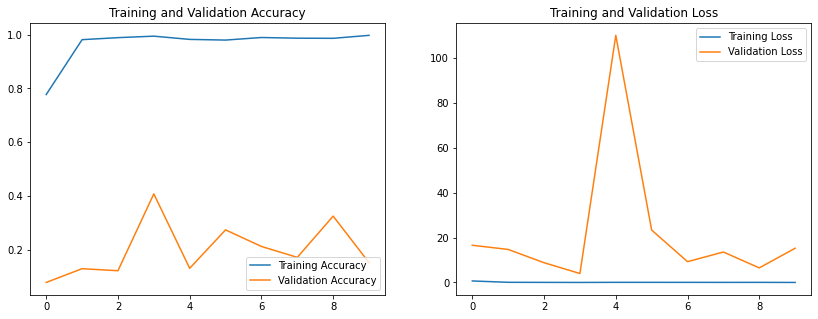

In [62]:

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
